In [1]:
import celloracle as co

/home/kwf2110/anaconda3/envs/celloracle/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/kwf2110/anaconda3/envs/celloracle/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/hom

In [5]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt

In [6]:
multiome_train_df = pd.read_parquet("./kaggle_files/multiome_train.parquet")
multiome_obs_df = pd.read_csv("./kaggle_files/multiome_obs_meta.csv")
multiome_var_df = pd.read_csv("./kaggle_files/multiome_var_meta.csv")

## Formatting scRNA-seq adata

In [10]:
# filtering scrna-seq data
genexp_var = multiome_var_df[multiome_var_df['feature_type']=='Gene Expression']
train_scrna = multiome_train_df[multiome_train_df['location'].isin(genexp_var['location'])]

In [11]:
obs_ids = train_scrna['obs_id'].unique()
obs_id_mapping = {obs_ids[i]: i for i in range(len(obs_ids))}
gene_symbols = genexp_var['location'].unique()
gene_mapping = {gene_symbols[i]: i for i in range(len(gene_symbols))}

In [9]:
def fill_X(X, train_scrna, verbose=False):
    for index, row in train_scrna.iterrows():
        i = obs_id_mapping[row['obs_id']]
        j = gene_mapping[row['location']]
        count = row['count']
        X[i, j] = count
    
        if verbose and index%500000 == 0:
            print("storing row ", index)

In [70]:
X = np.zeros((train_scrna['obs_id'].unique().shape[0], train_scrna['location'].unique().shape[0]))

In [ ]:
train_scrna_new = train_scrna.reset_index()
fill_X(X, train_scrna_new, verbose=True)

storing row  0
storing row  500000
storing row  1000000
storing row  1500000
storing row  2000000
storing row  2500000
storing row  3000000
storing row  3500000
storing row  4000000
storing row  4500000
storing row  5000000
storing row  5500000
storing row  6000000
storing row  6500000
storing row  7000000
storing row  7500000
storing row  8000000
storing row  8500000
storing row  9000000
storing row  9500000
storing row  10000000


In [77]:
np.save('X_scrna', X)

## scRNA-seq preprocessing

In [7]:
X_scrna = np.load('X_scrna.npy')

In [8]:
counts = csr_matrix(X_scrna)
adata_sc = ad.AnnData(counts)
adata_sc

AnnData object with n_obs × n_vars = 25551 × 22787

In [12]:
adata_sc.obs_names = obs_ids
adata_sc.var_names = gene_symbols

In [13]:
print(adata_sc.var_names[:10])

Index(['A1BG', 'A1BG-AS1', 'A2M', 'A2M-AS1', 'A2ML1', 'A2ML1-AS1', 'A3GALT2',
       'A4GALT', 'AAAS', 'AACS'],
      dtype='object')


In [14]:
sc_celltypes = multiome_obs_df[multiome_obs_df['obs_id'] == obs_ids]['cell_type']
adata_sc.obs['cell_type'] = pd.Categorical(sc_celltypes)
adata_sc.obs

,cell_type
000225c1151ab841,B cells
0003c40a54367871,T cells CD4+
0004bf574b822c3c,T cells CD4+
000d59b5478f28e2,B cells
0011b7473923d7b5,NK cells
...,...
fff2ca1f64c10339,T cells CD4+
fff87e64f509b570,T cells CD4+
fff9778b31bc2539,Myeloid cells
fffa92f71d2440de,NK cells


In [15]:
adata_sc

AnnData object with n_obs × n_vars = 25551 × 22787
    obs: 'cell_type'

In [16]:
sc.pp.filter_genes(adata_sc, min_counts=1)

In [17]:
sc.pp.normalize_per_cell(adata_sc, key_n_counts='n_counts_all')

In [18]:
# Select top 2000 highly-variable genes
filter_result = sc.pp.filter_genes_dispersion(adata_sc.X,
                                              flavor='cell_ranger',
                                              n_top_genes=2000,
                                              log=False)

# Subset the genes
adata_sc = adata_sc[:, filter_result.gene_subset]

# Renormalize after filtering
sc.pp.normalize_per_cell(adata_sc)

In [19]:
adata_sc

AnnData object with n_obs × n_vars = 25551 × 2000
    obs: 'cell_type', 'n_counts_all', 'n_counts'
    var: 'n_counts'

In [20]:
# keep raw cont data before log transformation
adata_sc.raw = adata_sc
adata_sc.layers["raw_count"] = adata_sc.raw.X.copy()

# Log transformation and scaling
sc.pp.log1p(adata_sc)
sc.pp.scale(adata_sc)

In [21]:
# PCA
sc.tl.pca(adata_sc, svd_solver='arpack')

# Diffusion map
sc.pp.neighbors(adata_sc, n_neighbors=4, n_pcs=20)

sc.tl.diffmap(adata_sc)
# Calculate neihbors again based on diffusionmap
sc.pp.neighbors(adata_sc, n_neighbors=10, use_rep='X_diffmap')

In [22]:
sc.tl.louvain(adata_sc, resolution=0.8)

In [23]:
# PAGA graph construction
sc.tl.paga(adata_sc, groups='louvain')

In [24]:
plt.rcParams["figure.figsize"] = [6, 4.5]

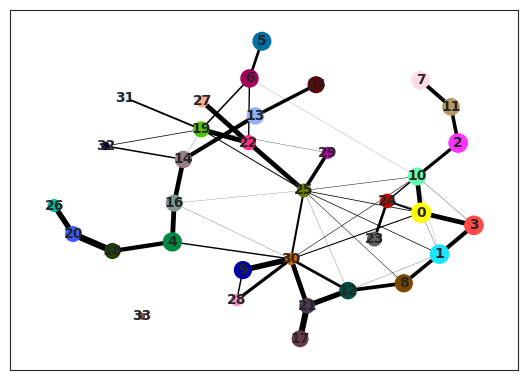

In [25]:
%matplotlib inline 
sc.pl.paga(adata_sc)

In [28]:
sc.tl.draw_graph(adata_sc, init_pos='paga', random_state=123)

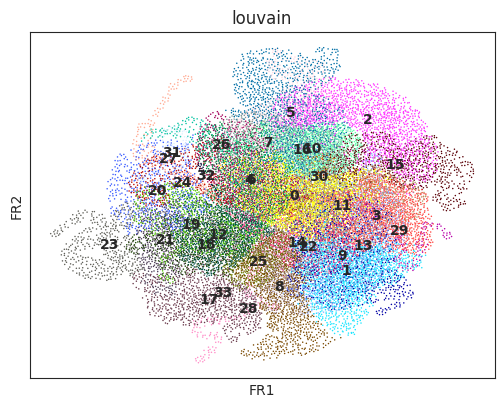

In [29]:
sc.pl.draw_graph(adata_sc, color='louvain', legend_loc='on data')

In [38]:
#sc.pl.paga(adata_sc, color=['louvain', 'CD18'])

In [39]:
adata_sc.write_h5ad("scrna.h5ad")